In [215]:
# text manipulation
import re
import string

# Data management
import pandas as pd
import numpy as np
from scipy.sparse import *
import scipy

# NLP
import nltk
import nltk.collocations as collocations
from nltk.tag import tnt
import spacy

# modelling
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.cluster import MeanShift

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output
import matplotlib.style as style 

%matplotlib inline

In [2]:
train = pd.read_csv('./train.csv')

In [3]:
no_insincere = train[train['target']==1].target.count()
no_sincere = train[train['target']==0].target.count()

print('No. of insincere questions:', no_insincere)
print('No. of sincere questions:', no_sincere)
print('% of insincere questions:', train.target.mean())
print('Null score:', 1- train.target.mean())

No. of insincere questions: 80810
No. of sincere questions: 1225312
% of insincere questions: 0.06187017751787352
Null score: 0.9381298224821265


# Define functions and pipelines

In [4]:
def vect_trans(vectorizer, X_train, X_test):
    # can also take a transformer
    vect = vectorizer
    vect.fit(X_train)
    return vect.transform(X_train), vect.transform(X_test)

In [5]:
# MultinominalNB function for printing scores and storing into df.
def model_score(model, X_train, X_test, y_train, y_test, score_df, model_label):
    estimator = model
    estimator.fit(X_train, y_train)
    test_score =  estimator.score(X_test, y_test)
    f1 = f1_score(y_test, estimator.predict(X_test))
    
    print('Train Accuracy :', estimator.score(X_train, y_train))
    print('Test Accuracy:', test_score)
    print('Test F1 score:', f1)
    score_df.loc[model_label, 'Test_Accuracy'] = test_score
    score_df.loc[model_label, 'Test_F1_score'] = f1

In [6]:
# Cross Validate function for printing scores and storing into df.
def cv_score(model, X, y, model_label,  cv=5, ):    
    
    # instantiating model
    estimator = model
    
    cv_result = cross_validate(estimator, X, y, cv = cv, n_jobs=-1, scoring=['accuracy', 'f1'])
    
    print('Test Accuracy Mean:',cv_result['test_accuracy'].mean())
    print('Test Accuracy STD:',cv_result['test_accuracy'].std())
    print('Test F1:', cv_result['test_f1'].mean())
    score_df.loc[model_label, 'CV_Accuracy'] = cv_result['test_accuracy'].mean()
    score_df.loc[model_label, 'CV_Acc_STD'] = cv_result['test_accuracy'].std()
    score_df.loc[model_label, 'CV_F1_score'] = cv_result['test_f1'].mean()

In [7]:
# GridSearchCV function, auto display best score and parameters and storing in df
def gridcv(model, X, y, params, cv= 5 ):
    
    # instantiating model can also be a pipeline
    estimator = model
    
    gridcv = GridSearchCV(estimator=estimator, param_grid=params, cv = cv, verbose=10, n_jobs=6)
    gridcv.fit(X, y)
    
    print(gridcv.best_params_)
    print(gridcv.best_score_)
    

In [10]:
# CountVectorizer pipeline and parameters
pipeCVNB = Pipeline([('CV',CountVectorizer(stop_words=stopwords)), 
                    ('NB',MultinomialNB())])

paramsCVNB = {'CV__max_df':(1.0, 0.9, 0.8, 0.7),
       'CV__min_df': (1, 2, 0.01 , 0.1, 0.2),
         'CV__ngram_range':((1,1), (1,2), (1,3))}

In [11]:
# TfidfVectorizer pipeline and parameters
pipeTVNB = Pipeline([('TV',TfidfVectorizer(stop_words=stopwords)), 
                    ('NB',MultinomialNB())])

paramsTVNB = {'TV__max_df':(1.0, 0.9, 0.8, 0.7, 0.6),
       'TV__min_df': (1, 2, 0.01, 0.05, 0.1),
         'TV__ngram_range':((1,1), (1,2), (1,3), (2,2), (2,3))}

In [12]:
score_df = pd.DataFrame()

# Lemmatization

In [80]:
%%time
clean_questions = (re.sub("[^A-Za-z']+", ' ', q).lower() for q in train['question_text'])

Wall time: 48 ms


In [85]:
# using spaCy to lemmatize using POS tags in one step, with out converting between WordNet and Treebank tags, using NLTK
spac = spacy.load('en', disable=['parser', 'ner'])
def lemmatizer(text):
    text = spac(text)
    return ' '.join([token.lemma_ for token in text if token.lemma_ not in stopwords])

In [86]:
%%time
lemma_q = [lemmatizer(q) for q in train.question_text]

Wall time: 1h 7min 12s


In [87]:
lemma_train = pd.DataFrame(lemma_q, columns = ['question_text'])
lemma_train['target'] = train.target
lemma_train.head()

,question_text,target
0,quebec nationalist see -PRON- province nation ...,0
1,-PRON- adopt dog would -PRON- encourage people...,0
2,velocity affect time velocity affect space geo...,0
3,otto von guericke use magdeburg hemisphere,0
4,-PRON- convert montra helicon mountain bike ch...,0


In [88]:
# lemma_train.to_pickle('./lemma_train.pkl')

In [156]:
lemma_train = pd.read_pickle('./lemma_train.pkl')

In [157]:
stopwords = list(nltk.corpus.stopwords.words('english')) + list(string.punctuation) + ["''", '``','’','“','”', "'s", "'d", "'ll", "'t", "n't", "ca", 'wo']

In [158]:
%%time
# remove stop words and lower all characters
clean_questions = [' '.join(w for w in nltk.word_tokenize(q.lower()) if w not in stopwords) for q in clean_questions]

Wall time: 2min


In [240]:
# replacing all identity labels each question with a common labels
def labels_to_question(data, label_list, label_type):
         
    new_data = []
    
    # For every questions
    i_data = 0
    for i_data in range(len(data)):
        question = data[i_data].lower()
        output = []
        
        # compare each label to question
        for label in label_list:

            if label in question:

                que_t = nltk.word_tokenize(question)
                lab_t = nltk.word_tokenize(label)

                i_que = 0
                while i_que < len(que_t):
                    i_lab = 0
                    
                    # If current token is same as first label token, continue compare rest of the tokens. 
                    if que_t[i_que] == lab_t[0]:
                        que_t[i_que] = label_type
                        i_lab += 1
                        i_que += 1

                        # Remove trailing question tokens if they match trailing label tokens
                        try: 
                            while i_lab < len(lab_t):
                                if que_t[i_que] == lab_t[i_lab]:
                                    que_t.pop(i_que)
                                    i_lab += 1
                                else:
                                    break
    #                     elif que_t[i_que] == lab_t[0]:
    #                         print('Question: ',question, i_data)
    #                         print('label: ', label)
                        except:
                            pass
                    i_que += 1
                question = ' '.join(que_t)
#                 print('after: ', question)
#                 print('label: ', label)
        new_data.append(question)                   
        if i_data % 1000 == 0:
            clear_output(wait=True)
            print(label_type, i_data)
    return new_data


In [241]:
# Identity groupd filters, created from online lists, most frequent insincere words and manual editing.
ID_filter = pd.read_csv('ID_filter.csv')

In [242]:
ID_filter.head(2)

,RELIGIOUS_ID,RACIAL_ID,NATIONAL_ID,NATIONALITY_ID,GENDER_ID,Unnamed: 5,Political_groups,Political_figure
0,buddhist,white people,Afghanistan,Afghans,girls,NaN,trump supporters,donald trump
1,catholic,black people,Albania,Albanians,boys,NaN,democrate,president trump


In [243]:
religious_ID = ID_filter.RELIGIOUS_ID.dropna()
racial_ID = ID_filter.RACIAL_ID.dropna()
national_ID = ID_filter.NATIONAL_ID.dropna()
nationality_ID = ID_filter.NATIONALITY_ID.dropna()



In [244]:
%%time
clean_questions = labels_to_question(clean_questions, religious_ID, 'RELIGIOUS_ID')
clean_questions = labels_to_question(clean_questions, racial_ID, 'RACIAL_ID')
clean_questions = labels_to_question(clean_questions, national_ID, 'NATIONAL_ID')
clean_questions = labels_to_question(clean_questions, nationality_ID, 'NATIONALITY_ID')

NATIONALITY_ID 1306000
Wall time: 3min 19s


In [245]:
X = clean_questions
y = lemma_train.target

In [246]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 495)

# Default count vectorizer on raw text

In [247]:
%%time

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(train.question_text, train.target,
                                                                    stratify=train.target, random_state = 495)

X_train_raw_t, X_test_raw_t=  vect_trans(CountVectorizer(), X_train_raw, X_test_raw)

Wall time: 35.2 s


In [248]:
model = MultinomialNB()
model_label = 'Raw_token_NB'

model_score(model, X_train_raw_t, X_test_raw_t, y_train_raw, y_test_raw, score_df, model_label)
cv_score(model, X_train_raw_t, y_train_raw, model_label)
score_df

Train Accuracy : 0.9350739237089765
Test Accuracy: 0.9344135778838762
Test F1 score: 0.5646092542896641
Test Accuracy Mean: 0.9321614838567932
Test Accuracy STD: 0.0005228593021778298
Test F1: 0.5489215714930169


,Test_Accuracy,Test_F1_score,CV_Accuracy,CV_Acc_STD,CV_F1_score
Raw_token_NB,0.934414,0.564609,0.932161,0.000523,0.548922
Token_NB,0.937219,0.556143,0.932638,0.000459,0.530513
Bigram_NB,0.947245,0.396637,0.944612,0.000376,0.481289
Trigram_NB,0.944777,0.271846,0.944942,0.000415,0.508322
Tfidf_t_NB,0.941736,0.147893,0.940431,0.000149,0.112072
Bigram_best_NB,0.937383,0.555746,0.933297,0.000458,0.533363
Trigram_best_NB,0.937387,0.555688,0.933304,0.000452,0.533348


In [249]:
nb = MultinomialNB()
nb.fit(X_train_raw_t, y_train_raw)  
test_score =  nb.score(X_test_raw_t, y_test_raw)
print('train score:', nb.score(X_train_raw_t, y_train_raw))
print('test score:', test_score)
y_pred = nb.predict(X_test_raw_t)

train score: 0.9350739237089765
test score: 0.9344135778838762


In [250]:
print(f1_score(y_test_raw, y_pred) )
print(f1_score(y_test_raw, y_pred, average='macro') )
print(f1_score(y_test_raw, y_pred, average='micro') )
print(f1_score(y_test_raw, y_pred, average='weighted') )
confusion_matrix(y_test_raw, y_pred)

0.5646092542896641
0.7645724512273393
0.9344135778838762
0.9397915566837656


array([[291229,  15099],
       [  6317,  13886]], dtype=int64)

# Basic Token and Ngram modelling on cleaned data

Creating train/test sets

In [251]:
X = clean_questions
y = train.target

In [252]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 495)

### Tokens only

In [253]:
%%time
X_train_t, X_test_t=  vect_trans(CountVectorizer(max_df=1.0, min_df=1, ngram_range=(1,1)), X_train, X_test)

Wall time: 20.8 s


In [254]:
model = MultinomialNB()
model_label = 'Token_NB'
X_train_arg = X_train_t
X_test_arg = X_test_t

model_score(model, X_train_arg, X_test_arg, y_train, y_test, score_df, model_label)
cv_score(model, X_train_arg, y_train, model_label)
score_df

Train Accuracy : 0.9375157591280443
Test Accuracy: 0.9368084500399656
Test F1 score: 0.5530864197530864
Test Accuracy Mean: 0.9322002750907756
Test Accuracy STD: 0.0004858539885341205
Test F1: 0.5273019796267486


,Test_Accuracy,Test_F1_score,CV_Accuracy,CV_Acc_STD,CV_F1_score
Raw_token_NB,0.934414,0.564609,0.932161,0.000523,0.548922
Token_NB,0.936808,0.553086,0.932200,0.000486,0.527302
Bigram_NB,0.947245,0.396637,0.944612,0.000376,0.481289
Trigram_NB,0.944777,0.271846,0.944942,0.000415,0.508322
Tfidf_t_NB,0.941736,0.147893,0.940431,0.000149,0.112072
Bigram_best_NB,0.937383,0.555746,0.933297,0.000458,0.533363
Trigram_best_NB,0.937387,0.555688,0.933304,0.000452,0.533348


### All Bigrams

In [255]:
%%time
X_train_bi, X_test_bi=  vect_trans(CountVectorizer(ngram_range=(1,2)), X_train, X_test)

Wall time: 58.3 s


Naive Bayes

In [256]:
model = MultinomialNB()
model_label = 'Bigram_NB'
X_train_arg = X_train_bi
X_test_arg = X_test_bi

model_score(model, X_train_arg, X_test_arg, y_train, y_test, score_df, model_label)
cv_score(model, X_train_arg, y_train, model_label)
score_df

Train Accuracy : 0.9739381027387961
Test Accuracy: 0.9469973754406167
Test F1 score: 0.3953463997484541
Test Accuracy Mean: 0.9443043071510162
Test Accuracy STD: 0.0004189333820907424
Test F1: 0.4772300836991656


,Test_Accuracy,Test_F1_score,CV_Accuracy,CV_Acc_STD,CV_F1_score
Raw_token_NB,0.934414,0.564609,0.932161,0.000523,0.548922
Token_NB,0.936808,0.553086,0.932200,0.000486,0.527302
Bigram_NB,0.946997,0.395346,0.944304,0.000419,0.477230
Trigram_NB,0.944777,0.271846,0.944942,0.000415,0.508322
Tfidf_t_NB,0.941736,0.147893,0.940431,0.000149,0.112072
Bigram_best_NB,0.937383,0.555746,0.933297,0.000458,0.533363
Trigram_best_NB,0.937387,0.555688,0.933304,0.000452,0.533348


Random Forest

In [257]:
# %%time
# model = RandomForestClassifier(n_estimators= 100, max_depth=20, n_jobs=-1)
# model_label = 'Bigram_RF'


# model_score(model, X_train_bi, X_test_bi, y_train, y_test, score_df, model_label)
# cv_score(model, X_train_bi, y_train, model_label)
# score_df

In [258]:
# score_df

### Tri-gram

In [259]:
%%time
X_train_tri, X_test_tri=  vect_trans(CountVectorizer(ngram_range=(1,3), stop_words=stopwords), X_train, X_test)

Wall time: 1min 32s


Naive Bayes

In [260]:
model = MultinomialNB()
model_label = 'Trigram_NB'
X_train_arg = X_train_tri
X_test_arg = X_test_tri

model_score(model, X_train_arg, X_test_arg, y_train, y_test, score_df, model_label)
cv_score(model, X_train_arg, y_train, model_label)
score_df

Train Accuracy : 0.987748968702244
Test Accuracy: 0.9445810658099844
Test F1 score: 0.26937984496124034
Test Accuracy Mean: 0.9445799319383473
Test Accuracy STD: 0.0003738154615595804
Test F1: 0.5034396610971816


,Test_Accuracy,Test_F1_score,CV_Accuracy,CV_Acc_STD,CV_F1_score
Raw_token_NB,0.934414,0.564609,0.932161,0.000523,0.548922
Token_NB,0.936808,0.553086,0.932200,0.000486,0.527302
Bigram_NB,0.946997,0.395346,0.944304,0.000419,0.477230
Trigram_NB,0.944581,0.269380,0.944580,0.000374,0.503440
Tfidf_t_NB,0.941736,0.147893,0.940431,0.000149,0.112072
Bigram_best_NB,0.937383,0.555746,0.933297,0.000458,0.533363
Trigram_best_NB,0.937387,0.555688,0.933304,0.000452,0.533348


Random Forest

In [261]:
# %%time
# model = RandomForestClassifier(n_estimators= 100, max_depth=20, n_jobs=-1)
# model_label = 'Trigram_RF'

# model_score(model, X_train_tri, X_test_tri, y_train, y_test, score_df, model_label)
# cv_score(model, X_train_tri, y_train, model_label)


In [262]:
# score_df

### GridSearch min/max df

In [263]:
# params = {'CV__max_df':(1.0, 0.9),
#        'CV__min_df': (1, 2, 0.01, 0.02),
#         'CV__ngram_range':((1,1), (1,2), (1,3))}

# gridcv(pipeCVNB, X_train, y_train, params)

In [264]:
# %%time
# X_train_t, X_test_t=  vect_trans(CountVectorizer(max_df=1.0, min_df=1, ngram_range=(1,2), 
#                                                     stop_words=stopwords), X_train, X_test)

In [265]:
# model = MultinomialNB()
# model_label = 'Grid_DFNB'

# model_score(model, X_train_t, X_test_t, y_train, y_test, score_df, model_label)
# cv_score(model, X_train_t, y_train, model_label)
# score_df

### TFIDF

In [266]:
X_train_tf_t, X_test_tf_t = vect_trans(TfidfTransformer(), X_train_t, X_test_t)

In [267]:
model = MultinomialNB()
model_label = 'Tfidf_t_NB'

model_score(model, X_train_tf_t , X_test_tf_t, y_train, y_test, score_df, model_label)
cv_score(model, X_train_tf_t, y_train, model_label)
score_df

Train Accuracy : 0.9426342218333978
Test Accuracy: 0.9411663823649209
Test F1 score: 0.12847616023227326
Test Accuracy Mean: 0.940048449146909
Test Accuracy STD: 0.0001397279742376803
Test F1: 0.09784554938584501


,Test_Accuracy,Test_F1_score,CV_Accuracy,CV_Acc_STD,CV_F1_score
Raw_token_NB,0.934414,0.564609,0.932161,0.000523,0.548922
Token_NB,0.936808,0.553086,0.932200,0.000486,0.527302
Bigram_NB,0.946997,0.395346,0.944304,0.000419,0.477230
Trigram_NB,0.944581,0.269380,0.944580,0.000374,0.503440
Tfidf_t_NB,0.941166,0.128476,0.940048,0.000140,0.097846
Bigram_best_NB,0.937383,0.555746,0.933297,0.000458,0.533363
Trigram_best_NB,0.937387,0.555688,0.933304,0.000452,0.533348


In [268]:
nb = MultinomialNB()
nb.fit(X_train_tf_t, y_train)  
test_score =  nb.score(X_test_tf_t, y_test)
print('train score:', nb.score(X_train_tf_t, y_train))
print('test score:', test_score)
y_pred = nb.predict(X_test_tf_t)

train score: 0.9426342218333978
test score: 0.9411663823649209


In [269]:
print(f1_score(y_test, y_pred) )
print(f1_score(y_test, y_pred, average='macro') )
print(f1_score(y_test, y_pred, average='micro') )
print(f1_score(y_test, y_pred, average='weighted') )
confusion_matrix(y_test, y_pred)

0.12847616023227326
0.5490158760303643
0.9411663823649209
0.9175166498703021


array([[305904,    424],
       [ 18787,   1416]], dtype=int64)

### NLTK Best Bigrams

In [270]:
# recreate text using ngrams
def ngram_to_corpus(data, ngram_list, n):
#     ngram_list = set({('let', 'us'), ('as', 'soon')})  # {('let', 'us'), ('as', 'soon')}
#     tokens = ['please', 'let', 'us', 'know', 'as', 'soon', 'as', 'possible']
    new_data = []
    for text in data:
        tokens = nltk.word_tokenize(text)
        output = []
        q_iter = iter(range(len(tokens)))
        
        for idx in q_iter:
            output.append(tokens[idx])
            if n == 2:
                if idx < (len(tokens) - 1) and (tokens[idx], tokens[idx+1]) in ngram_list:
                    output[-1] += '_' + tokens[idx+1]
                    next(q_iter)
            elif n == 3:
                if idx < (len(tokens) - 2) and (tokens[idx], tokens[idx+1], tokens[idx+2] ) in ngram_list:
                    output[-1] += '_' + tokens[idx+1] + '_' + tokens[idx+2]
                    next(q_iter)
                    next(q_iter)
        new_data.append( ' '.join(output))

    return new_data

In [271]:
%%time
# create one list of all question tokens
full_text = []

for text in X_train:
    full_text += [w for w in nltk.word_tokenize(text) if w not in stopwords]

Wall time: 1min 54s


In [272]:
len(full_text)

6274209

In [273]:
if 'would' in stopwords:
    print(True)

In [274]:
%%time
# create bigram vocabulary
bigram_measures = collocations.BigramAssocMeasures()

finder = nltk.BigramCollocationFinder.from_words(full_text)
# scored = finder.score_ngrams( bigram_measures.likelihood_ratio  )
bigram_vocab = finder.nbest(bigram_measures.likelihood_ratio, 80)
print(bigram_vocab)

[('united', 'states'), ('year', 'old'), ('best', 'way'), ('donald', 'trump'), ('computer', 'science'), ('even', 'though'), ('high', 'school'), ('social', 'media'), ('would', 'happen'), ('north', 'korea'), ('pros', 'cons'), ('get', 'rid'), ('major', 'accomplishments'), ('jee', 'mains'), ('look', 'like'), ('would', 'win'), ('x', 'x'), ('new', 'york'), ('machine', 'learning'), ('harry', 'potter'), ('years', 'old'), ('real', 'estate'), ('ssc', 'cgl'), ('long', 'take'), ('saudi', 'arabia'), ('feel', 'like'), ('star', 'wars'), ('long', 'term'), ('mechanical', 'engineering'), ('elon', 'musk'), ('tv', 'show'), ('e', 'g'), ('hillary', 'clinton'), ('hong', 'kong'), ('tamil', 'nadu'), ('short', 'term'), ('president', 'trump'), ('useful', 'tips'), ('san', 'francisco'), ('b', 'tech'), ('artificial', 'intelligence'), ('prime', 'minister'), ('different', 'types'), ('tv', 'series'), ('years', 'ago'), ('credit', 'card'), ('literary', 'devices'), ('narendra', 'modi'), ('new', 'zealand'), ('many', 'peopl

In [275]:
%%time
# create bigram vocabulary
bigram_measures = collocations.BigramAssocMeasures()


finder3 = nltk.BigramCollocationFinder.from_words(full_text)
finder3.apply_freq_filter(10)
finder3.apply_word_filter(lambda x: x in stopwords)
best_pmi = finder3.nbest(bigram_measures.pmi, 200)
print(best_pmi)

[('schr', 'dinger'), ('pepto', 'bismol'), ('michio', 'kaku'), ('neman', 'ashraf'), ('roald', 'dahl'), ('rudyard', 'kipling'), ('muhoozi', 'kainerugaba'), ('avada', 'kedavra'), ('aam', 'aadmi'), ('buenos', 'aires'), ('jaggi', 'vasudev'), ('disha', 'patani'), ('ronda', 'rousey'), ('abercrombie', 'fitch'), ('mosin', 'nagant'), ('zaira', 'wasim'), ('endoplasmic', 'reticulum'), ('deng', 'xiaoping'), ('gilgit', 'baltistan'), ('nathuram', 'godse'), ('sushma', 'swaraj'), ('jiang', 'zemin'), ('vande', 'mataram'), ('meryl', 'streep'), ('pakatan', 'harapan'), ('asim', 'qureshi'), ('sylvia', 'plath'), ('lata', 'mangeshkar'), ('sindhu', 'satish'), ('dima', 'vorobiev'), ('kalpit', 'veerwal'), ('pradhan', 'mantri'), ('aldous', 'huxley'), ('narsee', 'monjee'), ('ulcerative', 'colitis'), ('gauri', 'lankesh'), ('hadron', 'collider'), ('ballon', "d'or"), ('jiu', 'jitsu'), ('shel', 'silverstein'), ('mitt', 'romney'), ('khaled', 'hosseini'), ('petyr', 'baelish'), ('sourav', 'ganguly'), ('satoshi', 'nakamot

In [276]:
%%time
# create trigram vocabulary
trigram_measures = collocations.TrigramAssocMeasures()
finder = nltk.TrigramCollocationFinder.from_words(full_text)
trigram_vocab = finder.nbest(trigram_measures.likelihood_ratio, 20)
print(trigram_vocab)

[('united', 'states', 'america'), ('president', 'united', 'states'), ('united', 'states', 'india'), ('states', 'united', 'states'), ('history', 'united', 'states'), ('united', 'states', 'constitution'), ('united', 'states', 'government'), ('united', 'states', 'matter'), ('united', 'states', 'like'), ('united', 'states', 'army'), ('united', 'states', 'usa'), ('united', 'states', 'us'), ('united', 'states', 'united'), ('coast', 'united', 'states'), ('south', 'united', 'states'), ('canada', 'united', 'states'), ('united', 'states', 'military'), ('united', 'states', 'marine'), ('outside', 'united', 'states'), ('happen', 'united', 'states')]
Wall time: 8min 59s


In [277]:
%%time
# create text with bigram replacement
train['bigram_question_lkhd'] = ngram_to_corpus(clean_questions, bigram_vocab, 2)

Wall time: 2min 36s


In [278]:
%%time
# create text with both tri and bigram in text, by applying trigram first
train['trigram_question_lkhd'] = ngram_to_corpus(clean_questions, trigram_vocab, 3)
train['trigram_question_lkhd'] = ngram_to_corpus(train['trigram_question_lkhd'], bigram_vocab, 2)

Wall time: 5min 40s


In [279]:
train['trigram_question_lkhd'][20:25].values

array(['know whether girl done sex sex',
       'become fast learner professional career personal life',
       'united_states become largest dictatorship world',
       'strangest phenomenon know witnessed generated area electronics explanation terms modern physics',
       'leave friends find new ones'], dtype=object)

In [280]:
X = train[['bigram_question_lkhd','trigram_question_lkhd']]
y = train.target

In [281]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=495, test_size=0.2)

In [282]:
len(X_train)

1044897

In [283]:
X_train.head()

,bigram_question_lkhd,trigram_question_lkhd
1077331,procedure officially changing name india,procedure officially changing name india
334276,ancient egypt polytheism,ancient egypt polytheism
620299,whenever put blood pressure monitor get scared...,whenever put blood pressure monitor get scared...
1098236,ego react suicide,ego react suicide
548923,join tcs fresher missed campus hiring,join tcs fresher missed campus hiring


#### Bigram Model

In [284]:
# model using bigram text
X_train_bi, X_test_bi =  vect_trans(CountVectorizer(max_df=1.0,  min_df=1, ngram_range=(1,1), stop_words=stopwords),
                                   X_train.bigram_question_lkhd, X_test.bigram_question_lkhd,)



In [285]:
model = MultinomialNB()
model_label = 'Bigram_best_NB'

model_score(model, X_train_bi, X_test_bi, y_train, y_test, score_df, model_label)
cv_score(model, X_train_bi, y_train, model_label)
score_df

Train Accuracy : 0.9380637517382096
Test Accuracy: 0.9370466073308451
Test F1 score: 0.5530885670027448
Test Accuracy Mean: 0.9328287866087697
Test Accuracy STD: 0.0004956699857974989
Test F1: 0.5299533440504494


,Test_Accuracy,Test_F1_score,CV_Accuracy,CV_Acc_STD,CV_F1_score
Raw_token_NB,0.934414,0.564609,0.932161,0.000523,0.548922
Token_NB,0.936808,0.553086,0.932200,0.000486,0.527302
Bigram_NB,0.946997,0.395346,0.944304,0.000419,0.477230
Trigram_NB,0.944581,0.269380,0.944580,0.000374,0.503440
Tfidf_t_NB,0.941166,0.128476,0.940048,0.000140,0.097846
Bigram_best_NB,0.937047,0.553089,0.932829,0.000496,0.529953
Trigram_best_NB,0.937387,0.555688,0.933304,0.000452,0.533348


#### Trigram Model

In [286]:
# model using bigram text
X_train_tri, X_test_tri =  vect_trans(CountVectorizer(max_df=1.0,  min_df=1, ngram_range=(1,1), stop_words=stopwords),
                                   X_train.trigram_question_lkhd, X_test.trigram_question_lkhd)



In [287]:
model = MultinomialNB()
model_label = 'Trigram_best_NB'

model_score(model, X_train_tri, X_test_tri, y_train, y_test, score_df, model_label)
cv_score(model, X_train_tri, y_train, model_label)
score_df

Train Accuracy : 0.9380752361237519
Test Accuracy: 0.9370657479184611
Test F1 score: 0.5531394400652351
Test Accuracy Mean: 0.9328354858098556
Test Accuracy STD: 0.0004794080104813063
Test F1: 0.5299405877493948


,Test_Accuracy,Test_F1_score,CV_Accuracy,CV_Acc_STD,CV_F1_score
Raw_token_NB,0.934414,0.564609,0.932161,0.000523,0.548922
Token_NB,0.936808,0.553086,0.932200,0.000486,0.527302
Bigram_NB,0.946997,0.395346,0.944304,0.000419,0.477230
Trigram_NB,0.944581,0.269380,0.944580,0.000374,0.503440
Tfidf_t_NB,0.941166,0.128476,0.940048,0.000140,0.097846
Bigram_best_NB,0.937047,0.553089,0.932829,0.000496,0.529953
Trigram_best_NB,0.937066,0.553139,0.932835,0.000479,0.529941


In [288]:
# score_df.to_pickle('./lemmaID_score.pkl')

In [299]:
score_df = pd.read_pickle('./lemma_score.pkl')

### Visualisation

In [300]:
acc_df = pd.DataFrame(index=['Baseline','Raw Token', 'Tokens', 'All Bigram', 'All Trigram', 'TFIDF', 'N Bigram', 'N Trigram'])
acc_df['Accuracy'] = acc_list = [1-train.target.mean()] + list(score_df['Test_Accuracy'][:7])


In [301]:
f1_df =  pd.DataFrame(index=['Raw Token', 'Tokens', 'All Bigram', 'All Trigram', 'TFIDF', 'N Bigram', 'N Trigram'])
f1_df['F1 Score'] = list(score_df['Test_F1_score'][:7])


In [302]:
style.use('seaborn-poster')

style.use('seaborn-whitegrid') #sets the size of the charts
style.use('tableau-colorblind10')

In [303]:
acc_color = ['grey', 'coral', 'coral','coral','coral','coral','coral','coral']

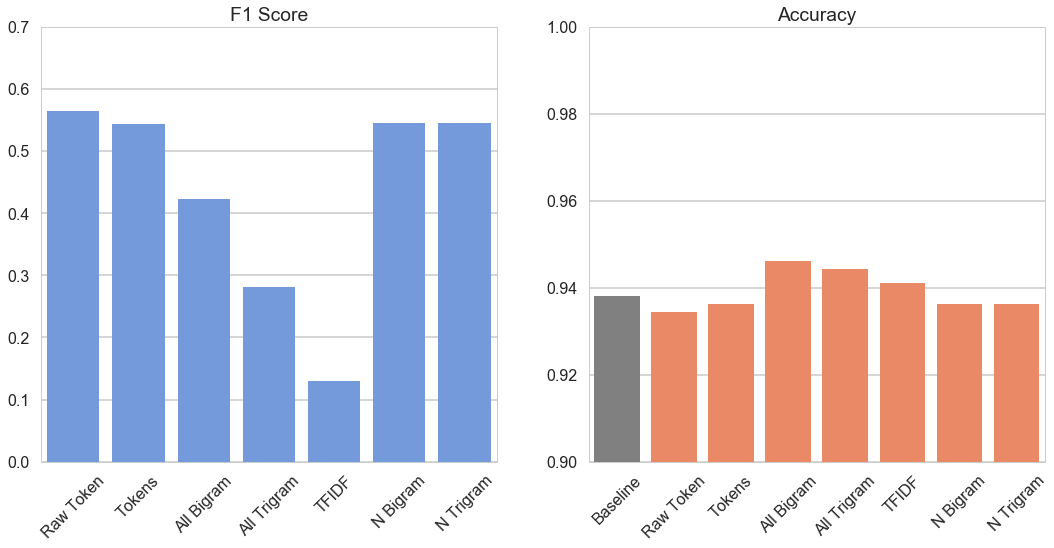

In [304]:
fig, ax = plt.subplots(1,2, figsize=(18,8))

ax1 = plt.subplot(121)
ax1 = sns.barplot(x=f1_df.index, y=f1_df['F1 Score'], color='cornflowerblue')
ax1 = plt.ylim(0, 0.7)
ax1 = plt.xticks(rotation=45)
ax1 = plt.title('F1 Score')
ax1 = plt.ylabel('')


ax2 = plt.subplot(122)
ax2 = sns.barplot(x=acc_df.index, y=acc_df.Accuracy, palette=acc_color)
ax2 = plt.ylim(0.9, 1)
ax2 = plt.xticks(rotation=45)
ax2 = plt.title('Accuracy')
ax2 = plt.ylabel('')


